# Climate Change Belief Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV 

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string
import re
nltk.download('stopwords')
porterStemmer = nltk.PorterStemmer()
wordNetLemma = nltk.WordNetLemmatizer()
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Train and Test Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [4]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [5]:
believe = train[train['sentiment'] == 1]
no_belief = train[train['sentiment'] == -1]
neutral = train[train['sentiment'] == 0]
news = train[train['sentiment'] == 2]

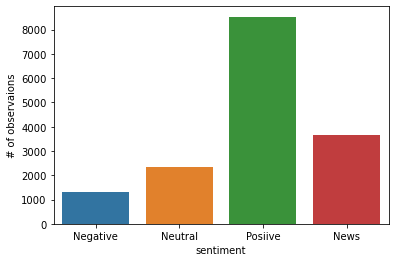

In [6]:
sns.countplot(x = 'sentiment', data = train).set_xticklabels(['Negative','Neutral','Posiive','News'])
plt.ylabel('# of observaions')
plt.show()

In [7]:
print(f"Percentage of Positive tweets: {int(np.round(len(believe)/len(train)*100,0))}%")
print(f"Percentage of Negative tweets: {int(np.round(len(no_belief)/len(train)*100,0))}%")
print(f"Percentage of Neutral tweets: {int(np.round(len(neutral)/len(train)*100,0))}%")
print(f"Percentage of News tweets: {int(np.round(len(news)/len(train)*100,0))}%")

Percentage of Positive tweets: 54%
Percentage of Negative tweets: 8%
Percentage of Neutral tweets: 15%
Percentage of News tweets: 23%


In [8]:
from sklearn.utils import resample

In [9]:
class_size = int(len(believe))

In [10]:
# Upsample mijority
no_belief_upsampled = resample(no_belief,
                          replace=True, 
                          n_samples=class_size, 
                          random_state=27) # reproducible results

news_upsampled = resample(news,
                          replace=True, 
                          n_samples=class_size,
                          random_state=27)

neutral_upsampled = resample(neutral,
                          replace=True, 
                          n_samples=class_size,
                          random_state=27)

#halving Positive values still we have huge amount of data now we downsample positive observation

# believe_downsampled = resample(believe,
#                           replace=True, 
#                           n_samples=class_size,
#                           random_state=27)


# Combine downsampled majority class with minority class
sampled_data = pd.concat([no_belief_upsampled, news_upsampled, neutral_upsampled, believe])

In [11]:
sampled_data.sentiment.value_counts()

-1    8530
 2    8530
 1    8530
 0    8530
Name: sentiment, dtype: int64

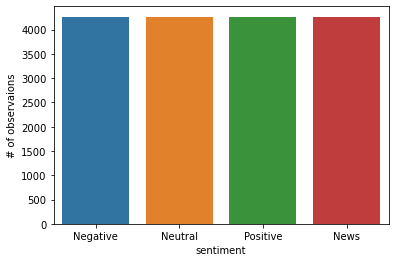

In [13]:
sns.countplot(x = 'sentiment', data = sampled_data).set_xticklabels(['Negative','Neutral','Positive','News'])
plt.ylabel('# of observaions')
plt.show()

## Data Cleaning and Text Preprocessing

In [12]:
def clean_message(message):
    message = re.sub(r'@[A-Za-z0-9]+','',message) ##Remove @aderate
    message = re.sub(r'#','',message) ##remove #hashtags
    message = re.sub(r'RT[\s]+', '', message) ## remove RT Retweets
    message = re.sub(r'https?:\/\/\S+', '', message) ##remove hyperlink
    message =  ''.join([char for char in message if char not in string.punctuation]) ## remove puntuations i.e. ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    message = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', message) # remove URLs
    message = re.sub(r'@[^\s]+', '', message) # remove usernames

    return message

In [13]:
#Clean Data and add new column called cleaned_message
sampled_data['cleaned_message'] = sampled_data['message'].apply(clean_message)

In [14]:
def remove_emojis(message):
    regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',message)

In [15]:
sampled_data['cleaned_message'] = sampled_data['cleaned_message'].apply(remove_emojis)

In [18]:
#Get subjectivity
def get_subjectivity(message):
    return TextBlob(message).sentiment.subjectivity

#Get Polarity
def get_polarity(message):
    return TextBlob(message).sentiment.polarity

sampled_data['subjectivity'] = sampled_data['cleaned_message'].apply(get_subjectivity)
sampled_data['polarity'] = sampled_data['cleaned_message'].apply(get_polarity)

In [16]:
believe_sampled = sampled_data[sampled_data['sentiment'] == 1]
no_belief_sampled = sampled_data[sampled_data['sentiment'] == -1]
neutral_sampled = sampled_data[sampled_data['sentiment'] == 0]
news_sampled = sampled_data[sampled_data['sentiment'] == 2]

In [17]:
sampled_data.head()

,sentiment,message,tweetid,cleaned_message
12819,-1,@ConnorDukeSmith climate change is fake #iamright,69529,climate change is fake iamright
6687,-1,RT @PolitixGal: When govt controls scientific ...,316086,When govt controls scientific research via gr...
9172,-1,@DRUDGE_REPORT 'Trump veers off script on clim...,106644,REPOTrump veers off script on climate change I...
12863,-1,I'm going to start replacing 'climate change' ...,527580,Im going to start replacing climate change wit...
1878,-1,RT @goburch: I just aint believing all that gl...,477516,I just aint believing all that global warming...


#### Plot WordCloud

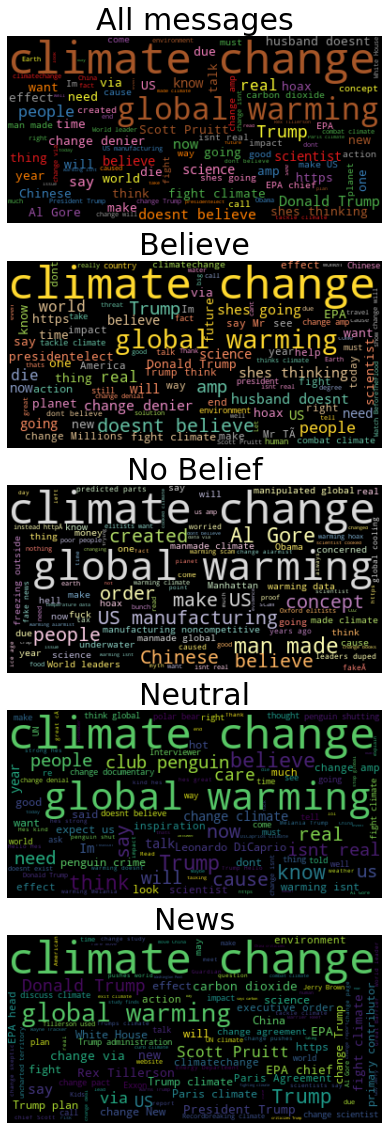

In [18]:
## plot word cloud (simply most used words in different sentiments)

allMessages = ' '.join([message for message in sampled_data['cleaned_message']])
message_belief = ' '.join(message for message in believe_sampled['cleaned_message'])
message_no_belief = ' '.join(message for message in no_belief_sampled['cleaned_message'])
message_neutral = ' '.join(message for message in neutral_sampled['cleaned_message'])
message_news = ' '.join(message for message in news_sampled['cleaned_message'])

wordCloud_all = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set1',stopwords = STOPWORDS, random_state= 42).generate(allMessages)

wordCloud_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set2' ,stopwords = STOPWORDS,random_state= 42).generate(message_belief)

wordCloud_no_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set3',stopwords = STOPWORDS, random_state= 42).generate(message_no_belief)

wordCloud_neutral = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_neutral)

wordCloud_news = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_news)

fig, ax = plt.subplots(5, 1, figsize  = (10,20))

ax[0].imshow(wordCloud_all, interpolation="bilinear")
ax[0].set_title('All messages', fontsize = 30)
ax[0].axis('off')

ax[1].imshow(wordCloud_belief, interpolation="bilinear")
ax[1].set_title('Believe', fontsize = 30)
ax[1].axis('off')

ax[2].imshow(wordCloud_no_belief, interpolation="bilinear")
ax[2].set_title('No Belief', fontsize = 30)
ax[2].axis('off')

ax[3].imshow(wordCloud_neutral, interpolation="bilinear")
ax[3].set_title('Neutral', fontsize = 30)
ax[3].axis('off')

plt.imshow(wordCloud_news, interpolation="bilinear")
plt.title('News', fontsize = 30)
plt.axis('off')
plt.show()

In [ ]:
#plot polarity and Subjectivity

plt.figure(figsize=(8,6))
#Check for last 100 message
for i in range(15719, train.shape[0]):
    plt.scatter(train['polarity'][i], train['subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

### Tokenization

In [19]:
def tokenization(message):
    message = word_tokenize(message)
    return message

sampled_data['message_tokenized'] = sampled_data['cleaned_message'].apply(lambda x: tokenization(x.lower()))

### Remove Stop Words

In [20]:
stopword = stopwords.words('english')

In [21]:
def remove_stopwords(message):
    filtered_message = [word for word in message if word not in stopword]
    return filtered_message
    
sampled_data['message_nonstop'] = sampled_data['message_tokenized'].apply(lambda x: remove_stopwords(x))

### Stemming and Lemmatization

In [22]:
#stemming removes or stems the last few characters of a word, often leading to incorrect meanings and spelling
def stemming(message):
    message = [porterStemmer.stem(word) for word in message]
    return message

sampled_data['message_stemmed'] = sampled_data['message_nonstop'].apply(lambda x: stemming(x))

In [23]:
#word lemma converts word to meaningful base (e.g truncation -> trunc)

def lemmatizer(message):
    return ' '.join([wordNetLemma.lemmatize(word) for word in message])

sampled_data['message'] = sampled_data['message_nonstop'].apply(lambda x: lemmatizer(x))

In [24]:
countVectorizer = CountVectorizer(analyzer=remove_stopwords) 
countVector = countVectorizer.fit_transform(sampled_data['message'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

34120 Number of tweets has 236 words


## Splitting out the X variable from the target

In [25]:
sampled_data.head()

,sentiment,message,tweetid,cleaned_message,message_tokenized,message_nonstop,message_stemmed
12819,-1,climate change fake iamright,69529,climate change is fake iamright,"[climate, change, is, fake, iamright]","[climate, change, fake, iamright]","[climat, chang, fake, iamright]"
6687,-1,govt control scientific research via grant mon...,316086,When govt controls scientific research via gr...,"[when, govt, controls, scientific, research, v...","[govt, controls, scientific, research, via, gr...","[govt, control, scientif, research, via, grant..."
9172,-1,repotrump veers script climate change one reve...,106644,REPOTrump veers off script on climate change I...,"[repotrump, veers, off, script, on, climate, c...","[repotrump, veers, script, climate, change, on...","[repotrump, veer, script, climat, chang, one, ..."
12863,-1,im going start replacing climate change chemos...,527580,Im going to start replacing climate change wit...,"[im, going, to, start, replacing, climate, cha...","[im, going, start, replacing, climate, change,...","[im, go, start, replac, climat, chang, chemosh..."
1878,-1,aint believing global warming bunk,477516,I just aint believing all that global warming...,"[i, just, aint, believing, all, that, global, ...","[aint, believing, global, warming, bunk]","[aint, believ, global, warm, bunk]"


In [26]:
X = sampled_data['message']
y = sampled_data['sentiment']

## Turning text into something  model can read

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

## Splitting the training data into a training and validation set

In [28]:
X_train,X_val,y_train,y_val = train_test_split(X_vectorized,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

## Training the model and evaluating using the validation set

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [35]:
names = ['Logistic Regression', 'Nearest Neighbors',
         'Linear SVM', 'RBF SVM',
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [36]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=1, C=1,kernel='rbf'),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

In [42]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_val)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred,average='macro')

    f1        = metrics.f1_score(y_train, y_pred, average='macro')
    f1_test   = metrics.f1_score(y_val, y_pred_test, average='macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring


In [43]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.996650,0.996654,0.996650,0.996651,0.871558,88.925135
Logistic Regression,0.953274,0.953331,0.953276,0.953202,0.857327,16.012337
Nearest Neighbors,0.897756,0.898014,0.897763,0.896668,0.751456,0.010040
AdaBoost,0.521437,0.562450,0.521429,0.525143,0.504121,31.058107
Linear SVM,0.436610,0.663004,0.436598,0.391517,0.377912,108.912930
Decision Tree,0.412075,0.533438,0.412063,0.368671,0.367311,1.091303
Random Forest,0.261849,0.755643,0.261891,0.124285,0.119376,0.155693


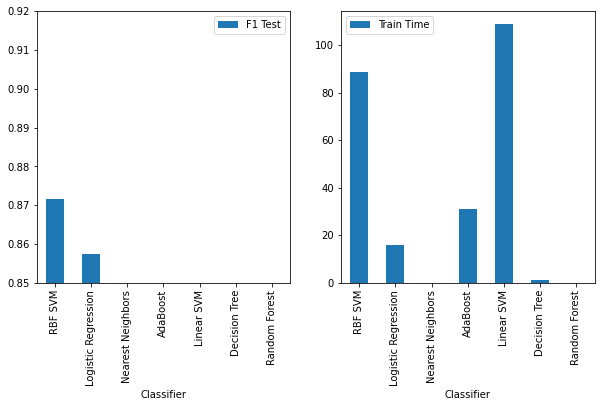

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results.plot(y='Train Time', kind='bar', ax=ax[1])

In [93]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

resultsKnn = []

for k in ks:
    print('Fitting KNN model with k = {:d}'.format(k))
    knn = KNeighborsClassifier(k)
    run_time = %timeit -q -o knn.fit(X_train, y_train)

    # predicting
    y_pred = knn.predict(X_train)
    y_pred_test = knn.predict(X_val)

    # scoring
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred, average='macro')
    f1        = metrics.f1_score(y_train, y_pred, average='macro')
    f1_test   = metrics.f1_score(y_val, y_pred_test, average='macro')

    # save the results 
    resultsKnn.append([k, accuracy, precision, recall, f1, f1_test, run_time.best])

resultsKnn = pd.DataFrame(resultsKnn, columns=['KNN', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
resultsKnn.set_index('K', inplace= True)

Fitting KNN model with k = 1
Fitting KNN model with k = 2
Fitting KNN model with k = 3
Fitting KNN model with k = 4
Fitting KNN model with k = 5
Fitting KNN model with k = 6
Fitting KNN model with k = 7
Fitting KNN model with k = 8
Fitting KNN model with k = 9
Fitting KNN model with k = 10
Fitting KNN model with k = 20
Fitting KNN model with k = 50


KeyError: "None of ['K'] are in the columns"

In [94]:
resultsKnn

,KNN,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
0,1,0.997320,0.997326,0.997320,0.997321,0.837821,0.005946
1,2,0.915592,0.919862,0.915603,0.915020,0.762824,0.007015
2,3,0.897756,0.898014,0.897763,0.896668,0.751456,0.007746
3,4,0.854463,0.854135,0.854474,0.852998,0.722752,0.008743
4,5,0.820298,0.819181,0.820306,0.819117,0.706242,0.008748
5,6,0.790069,0.789550,0.790078,0.788808,0.673899,0.008310
6,7,0.770725,0.769873,0.770730,0.770011,0.660682,0.010148
7,8,0.753308,0.753043,0.753313,0.752778,0.652468,0.009457
8,9,0.730447,0.730133,0.730451,0.730088,0.642841,0.008736
9,10,0.720315,0.720876,0.720318,0.720457,0.639743,0.008744


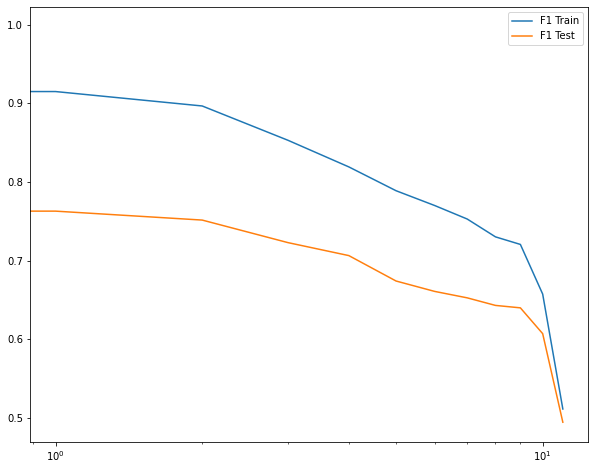

In [95]:
resultsKnn[['F1 Train', 'F1 Test']].plot(kind = 'line', figsize=(10, 8), logx=True)

In [96]:
param_grid = {'n_neighbors': ks}

In [98]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='f1')

In [45]:
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)

In [46]:
f1_score(y_val, knn_pred, average="macro")

0.9124131353911286

In [55]:
 
# defining parameter range 
param_grid = {'C': [0.1, 1],  
              'gamma': [1, 2], 
              'kernel': ['rbf']}  

In [56]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [57]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.535, total= 2.4min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.519, total= 2.8min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.488, total= 2.6min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.514, total= 2.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, tot

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1, 2], 'kernel': ['rbf']},
             verbose=3)

In [58]:

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


In [60]:

grid_predictions = grid.predict(X_val) 

In [64]:
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

          -1       0.97      0.93      0.95      1280
           0       0.88      0.86      0.87      1280
           1       0.79      0.85      0.82      1279
           2       0.88      0.88      0.88      1279

    accuracy                           0.88      5118
   macro avg       0.88      0.88      0.88      5118
weighted avg       0.88      0.88      0.88      5118



### Checking the performance of our model on the validation set

In [30]:
#Fit Model based on Grid Search best parameters ({'C': 1, 'gamma': 1, 'kernel': 'rbf'}
#SVC(C=1, gamma=1))

rbf = SVC(gamma=1, C=1,kernel='rbf')
rbf.fit(X_train, y_train)
rbf_pred = rbf.predict(X_val)

In [31]:
f1_score(y_val, rbf_pred, average="macro")

0.9461744057730463

In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

In [44]:
f1_score(y_val, lr_pred, average="macro")

0.9043578800266759

## Getting our test set ready

In [39]:
testx = test['message']
test_vect = vectorizer.transform(testx)

### Making predictions on the test set and adding a sentiment column to our original test df

In [47]:
y_pred = rbf.predict(test_vect)

In [48]:
test['sentiment'] = y_pred

In [49]:
test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,0
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


### Creating an output csv for submission

In [50]:
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)